In [1]:
# Compute DoLP and AoLP from 4xRGB tensor
def compute_dolp_aolp_tensor(polar_rgb):
    I0, I45, I90, I135 = [f.mean(axis=0) for f in polar_rgb]  # (H,W)
    S0 = 0.5 * (I0 + I90 + I45 + I135)
    S1 = I0 - I90
    S2 = I45 - I135
    dolp = np.clip(np.sqrt(S1**2 + S2**2)/(S0+1e-8), 0, 1)
    aolp = 0.5 * np.arctan2(S2, S1)
    return dolp, aolp


/opt/anaconda3/envs/polartact/lib/python3.13/site-packages/polanalyser/stokes.py:173: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(s1**2 + s2**2) / s0
/var/folders/yx/jx_z889n6dg9dzyx9rzsdnv80000gn/T/ipykernel_88392/3527014693.py:95: RuntimeWarning: invalid value encountered in cast
  Image.fromarray((normal_rgb*255).astype(np.uint8)).save(f"{save_root}/normal_rgb/{name}.png")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022646867..0.9837915].


▶ beads
▶ coin_500yen2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024342272..0.9665894].


▶ dog_tag5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027814973..0.7553149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.052096862..1.0402282].


▶ fish2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030643482..1.0600047].


▶ lunchtoy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06862425..1.0994469].


▶ necklace


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04944835..1.0212027].


▶ red_transparent


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10859151..1.1283158].


▶ screws


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026784176..1.0764581].


▶ shell_brown


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02168315..1.0343375].


▶ single_shell


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047194585..1.029221].


▶ stone_white


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.071746506..1.0967071].


▶ teapot


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022646867..0.9837915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022646867..0.9837915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024342272..0.9665894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024342272..0.9665894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027814973..0.7553149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027814973..0.7553149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

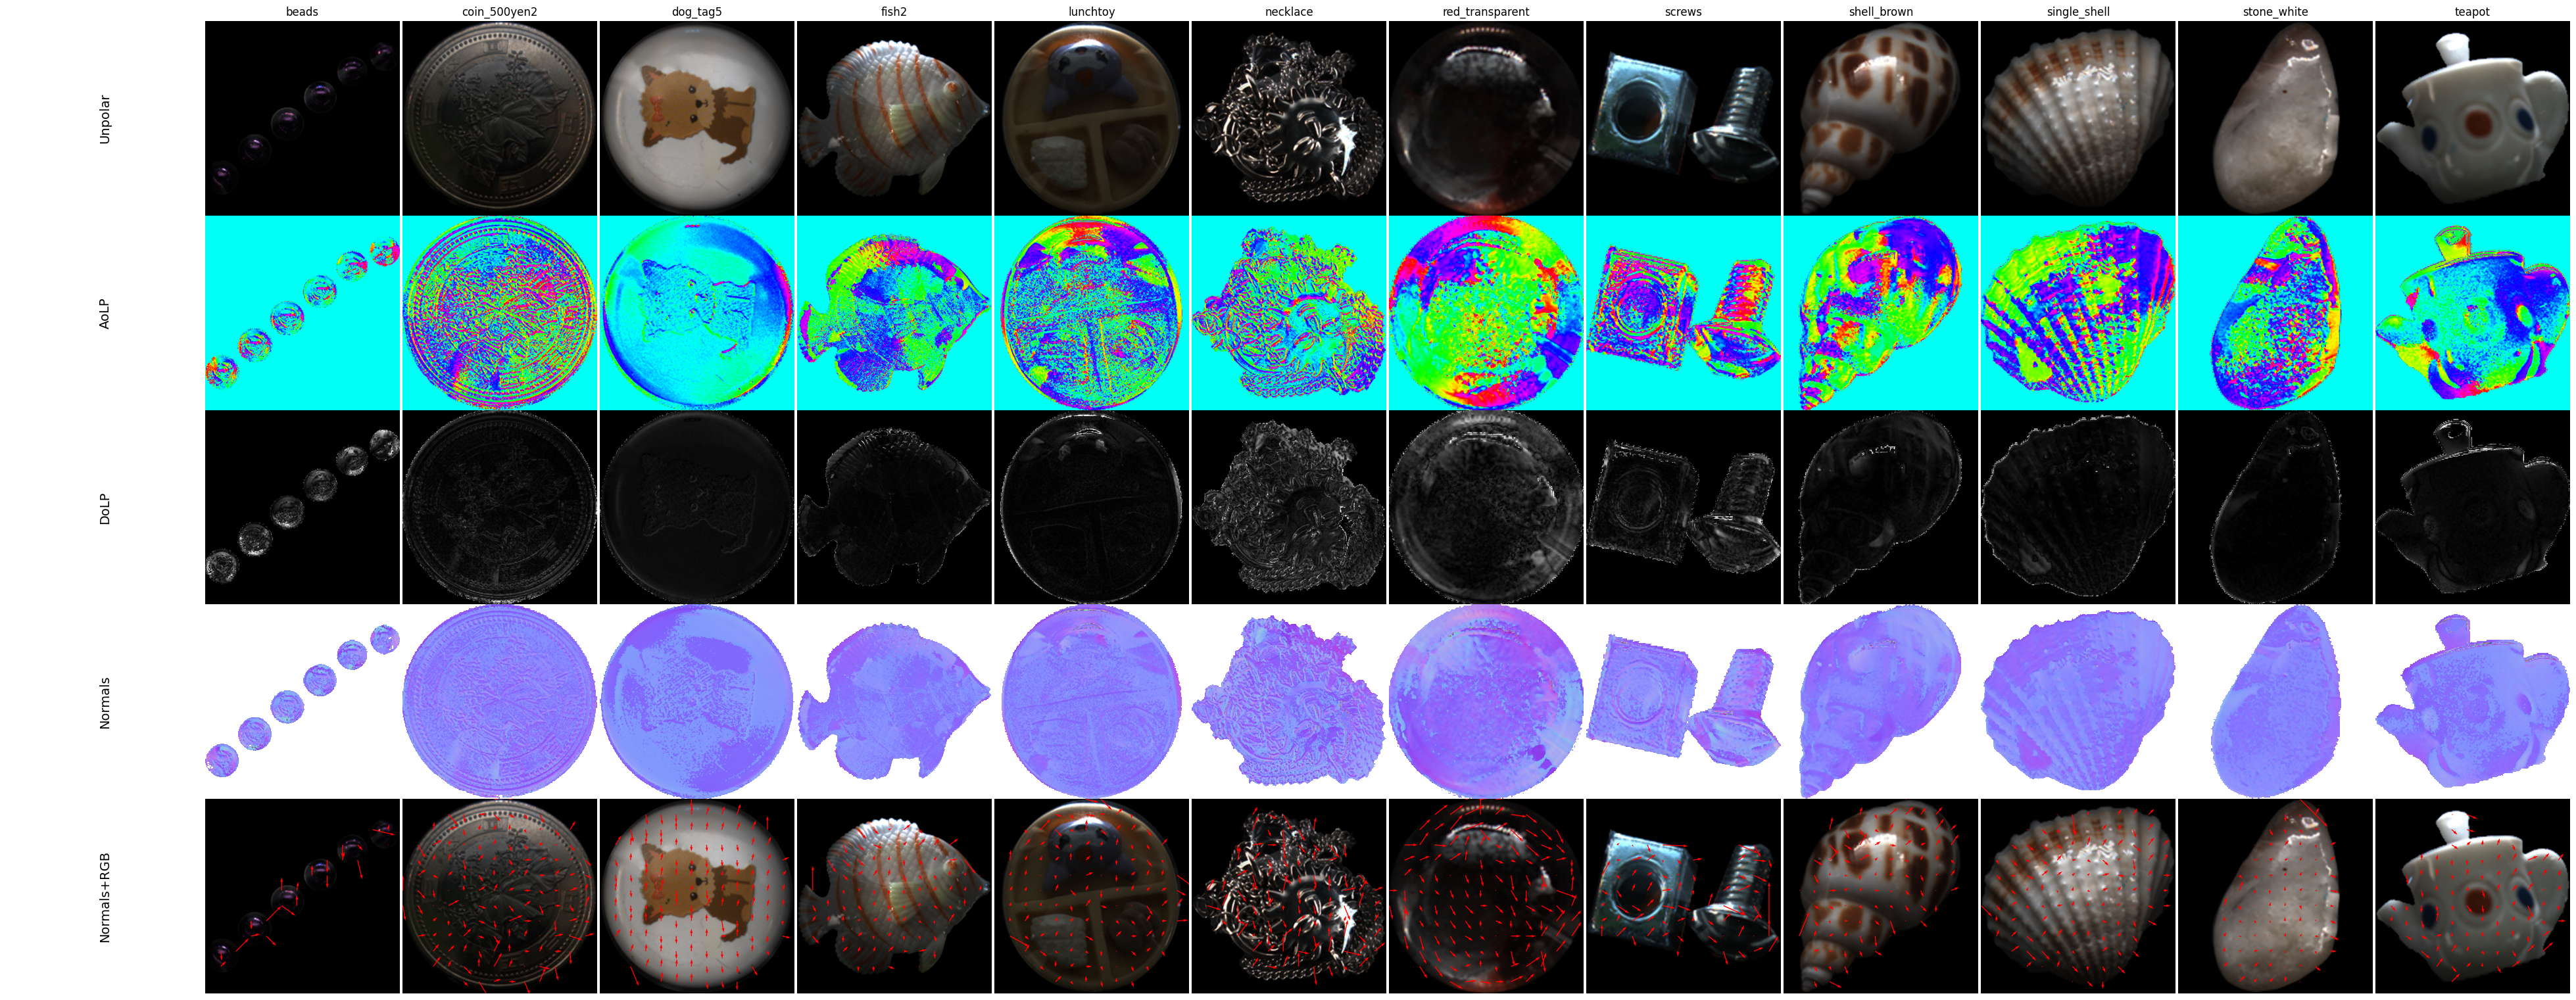

In [2]:
import os, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import polanalyser as pa
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from rho_spec import rho_spec
from surfaceNormal import surface_normal_from_zenith_azimuth

# --------------- CONFIG ------------------------------------------------
objects      = ['beads','coin_500yen2','dog_tag5','fish2','lunchtoy',
                'necklace','red_transparent','screws','shell_brown',
                'single_shell','stone_white','teapot']
base_dir     = "../data/masked_pol_img"
save_root    = "viz_results"
angles_rad   = np.deg2rad([0,45,90,135])
n_refrac     = 1.5
quiver_step  = 40
canvas_size  = 512                       # final square like learned model
arrow_scale  = 5

# ensure dirs
for d in ["unpolar","dolp","aolp","normal_rgb","normal_on_rgb"]:
    os.makedirs(f"{save_root}/{d}", exist_ok=True)

all_data = []

# --------------- helper: square-pad & resize ---------------------------
def square_resize(img, size=512, is_rgb=True):
    """Pad an image (H,W[,C]) to square, then resize to (size,size)."""
    h, w = img.shape[:2]
    s = max(h, w)
    pad_v = (s - h) // 2
    pad_h = (s - w) // 2
    if is_rgb:
        canvas = np.zeros((s, s, 3), img.dtype)
        canvas[pad_v:pad_v+h, pad_h:pad_h+w] = img
        return cv2.resize(canvas, (size, size), interpolation=cv2.INTER_CUBIC)
    else:
        canvas = np.zeros((s, s), img.dtype)
        canvas[pad_v:pad_v+h, pad_h:pad_h+w] = img
        return cv2.resize(canvas, (size, size), interpolation=cv2.INTER_CUBIC)

# --------------- MAIN LOOP --------------------------------------------
for name in objects:
    print("▶", name)

    # --- load four RGB images -----------------------------------------
    rgb = [
        cv2.cvtColor(
            cv2.imread(f"{base_dir}/pol{ang:03}/{name}.png"),
            cv2.COLOR_BGR2RGB).astype(np.float32)
        for ang in (0,45,90,135)
    ]

    # --- derive mask & bounding box -----------------------------------
    mask_bin = (rgb[0].sum(axis=2) > 0).astype(np.uint8)
    ys, xs = np.where(mask_bin)
    rs, re = ys.min(), ys.max()
    cs, ce = xs.min(), xs.max()

    # --- crop to ROI ---------------------------------------------------
    rgb_crop = [im[rs:re+1, cs:ce+1] for im in rgb]

    # --- square-pad & resize to 512 -----------------------------------
    rgb_sq = [square_resize(im, canvas_size, True) for im in rgb_crop]
    unpolar = np.mean(rgb_sq, axis=0) / 255.0                # [0,1]

    # Grays for Stokes
    grays = [cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_RGB2GRAY)
             for im in rgb_sq]
    stokes = pa.calcStokes(grays, angles_rad)
    dolp   = pa.cvtStokesToDoLP(stokes)
    aolp   = pa.cvtStokesToAoLP(stokes)
    theta  = rho_spec(dolp, n_refrac)

    # Normals
    normals = surface_normal_from_zenith_azimuth(theta, aolp)
    nx, ny, nz = normals[...,0], normals[...,1], normals[...,2]
    H = W = canvas_size

    # Common visual maps
    aolp_vis = ((aolp + np.pi/2) / np.pi) % 1.0
    aolp_rgb = plt.cm.hsv(aolp_vis)[...,:3]
    normal_rgb = np.stack([(nx+1)/2, (ny+1)/2, (nz+1)/2], axis=-1).clip(0,1)
    dolp_rgb = plt.cm.gray(np.clip(dolp,0,1))[...,:3]

    # Quiver grid
    ys, xs = np.mgrid[0:H:quiver_step, 0:W:quiver_step]
    U, V   = nx[ys,xs], ny[ys,xs]

    # --- save ---------------------------------------------------------
    Image.fromarray((unpolar*255).astype(np.uint8)).save(f"{save_root}/unpolar/{name}.png")
    Image.fromarray((dolp_rgb*255).astype(np.uint8)).save(f"{save_root}/dolp/{name}.png")
    Image.fromarray((aolp_rgb*255).astype(np.uint8)).save(f"{save_root}/aolp/{name}.png")
    Image.fromarray((normal_rgb*255).astype(np.uint8)).save(f"{save_root}/normal_rgb/{name}.png")

    fig,ax = plt.subplots(figsize=(5,5))
    ax.imshow(unpolar)
    ax.quiver(xs+.5, ys+.5, U, V, color='red', scale=arrow_scale, headwidth=3)
    ax.axis('off'); fig.tight_layout(pad=0)
    fig.savefig(f"{save_root}/normal_on_rgb/{name}.png", dpi=150)
    plt.close(fig)

    all_data.append({
        'name':name,'unpolar':unpolar,'aolp':aolp_rgb,'dolp':dolp_rgb,
        'normal_rgb':normal_rgb,'quiver':(xs+.5,ys+.5,U,V)
    })

# --------------- GRID -------------------------------------------------
row_keys   = ['unpolar','aolp','dolp','normal_rgb','unpolar']
row_labels = ['Unpolar','AoLP','DoLP','Normals','Normals+RGB']
cols       = len(all_data)
fig,axs    = plt.subplots(len(row_keys), cols+1, figsize=((cols+1)*3,15))

for r,(k,label) in enumerate(zip(row_keys,row_labels)):
    axs[r,0].axis('off')
    axs[r,0].text(0.5,0.5,label,ha='center',va='center',fontsize=14,rotation=90)

for c,obj in enumerate(all_data):
    for r,k in enumerate(row_keys):
        ax=axs[r,c+1]; ax.axis('off')
        ax.imshow(obj[k])
        if r==4:
            X,Y,U,V=obj['quiver']; ax.quiver(X,Y,U,V,color='red',scale=arrow_scale,headwidth=3)
        if r==0:
            ax.set_title(obj['name'])

plt.tight_layout(pad=0); plt.show()